# Integration and label transfer in scvi-tools with Tabula Muris




In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [2]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch

In [3]:
scvi.settings.seed = 0
print("scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


scvi-tools version: 1.1.5


In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [5]:
tm_droplet_path = os.path.join(save_dir.name, "TM_droplet.h5ad")
tm_facs_path = os.path.join(save_dir.name, "TM_facs.h5ad")

tm_droplet = sc.read(
    tm_droplet_path,
    backup_url="https://figshare.com/ndownloader/files/23938934",
)
tm_facs = sc.read(
    tm_facs_path,
    backup_url="https://figshare.com/ndownloader/files/23939711",
)

  0%|          | 0.00/3.78G [00:00<?, ?B/s]

  0%|          | 0.00/2.20G [00:00<?, ?B/s]

In [6]:
tm_droplet = tm_droplet[
    (tm_droplet.obs.tissue == "Marrow")
    & (~tm_droplet.obs.cell_ontology_class.isna())
    & (tm_droplet.obs.sex == "female")
].copy()
tm_facs = tm_facs[
    (tm_facs.obs.tissue == "Marrow")
    & (~tm_facs.obs.cell_ontology_class.isna())
    & (tm_facs.obs.sex == "female")
].copy()

tm_droplet.obs["tech"] = "10x"
tm_facs.obs["tech"] = "SS2"

In [7]:
import gc
gc.collect()

154

In [8]:
tm_droplet

AnnData object with n_obs × n_vars = 11707 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech'
    var: 'n_cells'

In [9]:
tm_facs

AnnData object with n_obs × n_vars = 4200 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'tech'
    var: 'n_cells'

In [13]:
import pandas as pd
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)
gene_len.head()

,1
0,
0610007C21Rik,94.571429
0610007L01Rik,156.000000
0610007P08Rik,202.272727
0610007P14Rik,104.000000
0610007P22Rik,158.750000


In [15]:
import numpy as np
gene_len = gene_len.reindex(tm_facs.var.index).dropna()
tm_facs = tm_facs[:, gene_len.index]
assert (tm_facs.var.index == gene_len.index).sum() == tm_facs.shape[1]
tm_facs.X = tm_facs.X / gene_len[1].values * np.median(gene_len[1].values)
# round to integer
tm_facs.X = np.rint(tm_facs.X)

In [17]:
import anndata
adata = anndata.concat([tm_droplet, tm_facs])
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="tech",
    subset=True,
)

In [18]:
adata

AnnData object with n_obs × n_vars = 15907 × 2000
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tech'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [19]:
adata.obs

,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,tissue,tech
index,,,,,,,,,,,,
AAACCTGGTAGTAGTA-1-2-0-0,18m,MACA_18m_F_BM_50_AAACCTGGTAGTAGTA,naive T cell,NA,nan,droplet,18-F-50,3736.0,female,nan,Marrow,10x
AAACGGGCATCGTCGG-1-2-0-0,18m,MACA_18m_F_BM_50_AAACGGGCATCGTCGG,hematopoietic precursor cell,NA,nan,droplet,18-F-50,2617.0,female,nan,Marrow,10x
AAACGGGGTGACAAAT-1-2-0-0,18m,MACA_18m_F_BM_50_AAACGGGGTGACAAAT,monocyte,NA,nan,droplet,18-F-50,1456.0,female,nan,Marrow,10x
AAAGATGGTGACTACT-1-2-0-0,18m,MACA_18m_F_BM_50_AAAGATGGTGACTACT,megakaryocyte-erythroid progenitor cell,NA,nan,droplet,18-F-50,1764.0,female,nan,Marrow,10x
AAAGATGTCTAAGCCA-1-2-0-0,18m,MACA_18m_F_BM_50_AAAGATGTCTAAGCCA,granulocytopoietic cell,NA,nan,droplet,18-F-50,1218.0,female,nan,Marrow,10x
...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA001844.3_38_F.1.1-1-1,3m,P9.MAA001844.3_38_F.1.1,hematopoietic stem cell,CL:0002035,MPP Fraction B,facs,3_38_F,2988.0,female,KLS,Marrow,SS2
P9.MAA001883.3_39_F.1.1-1-1,3m,P9.MAA001883.3_39_F.1.1,naive B cell,CL:0000788,naïve B cell,facs,3_39_F,1867.0,female,B-cells,Marrow,SS2
P9.MAA001884.3_38_F.1.1-1-1,3m,P9.MAA001884.3_38_F.1.1,precursor B cell,CL:0000817,pre B cell,facs,3_38_F,1527.0,female,B-cells,Marrow,SS2


In [20]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="tech")

In [22]:
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

In [23]:
scvi_model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [24]:
scvi_model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [08:07<00:00,  1.21s/it, v_num=1, train_loss_step=879, train_loss_epoch=1.05e+3]    

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [08:07<00:00,  1.22s/it, v_num=1, train_loss_step=879, train_loss_epoch=1.05e+3]


In [25]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [27]:
SCVI_MDE_KEY = "X_scVI_mde"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


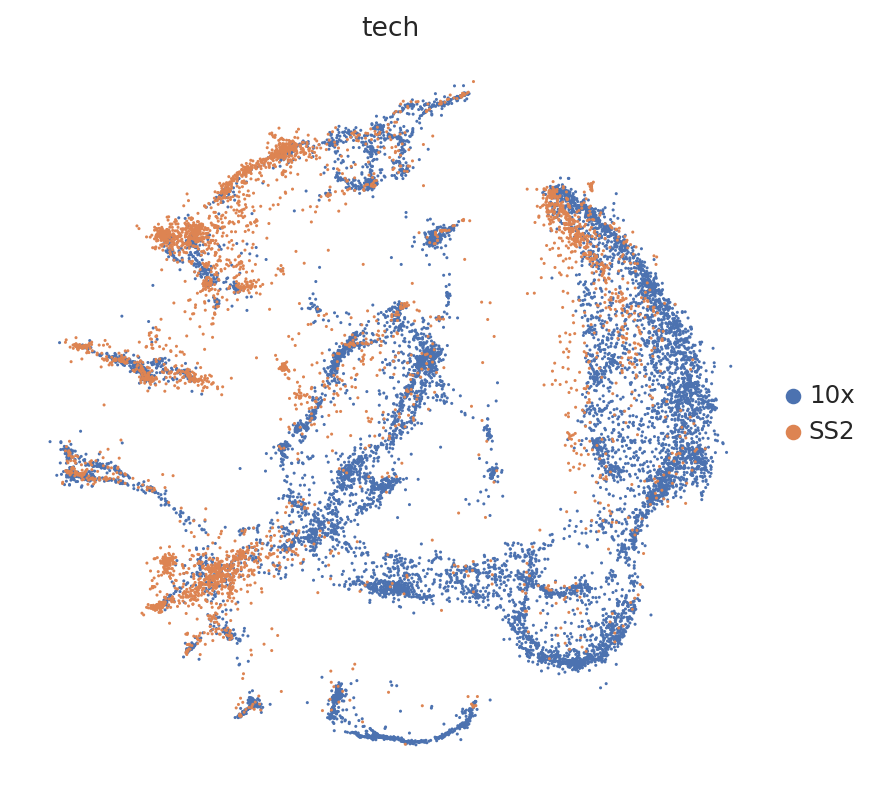

In [28]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["tech"],
    frameon=False,
    ncols=1,
)

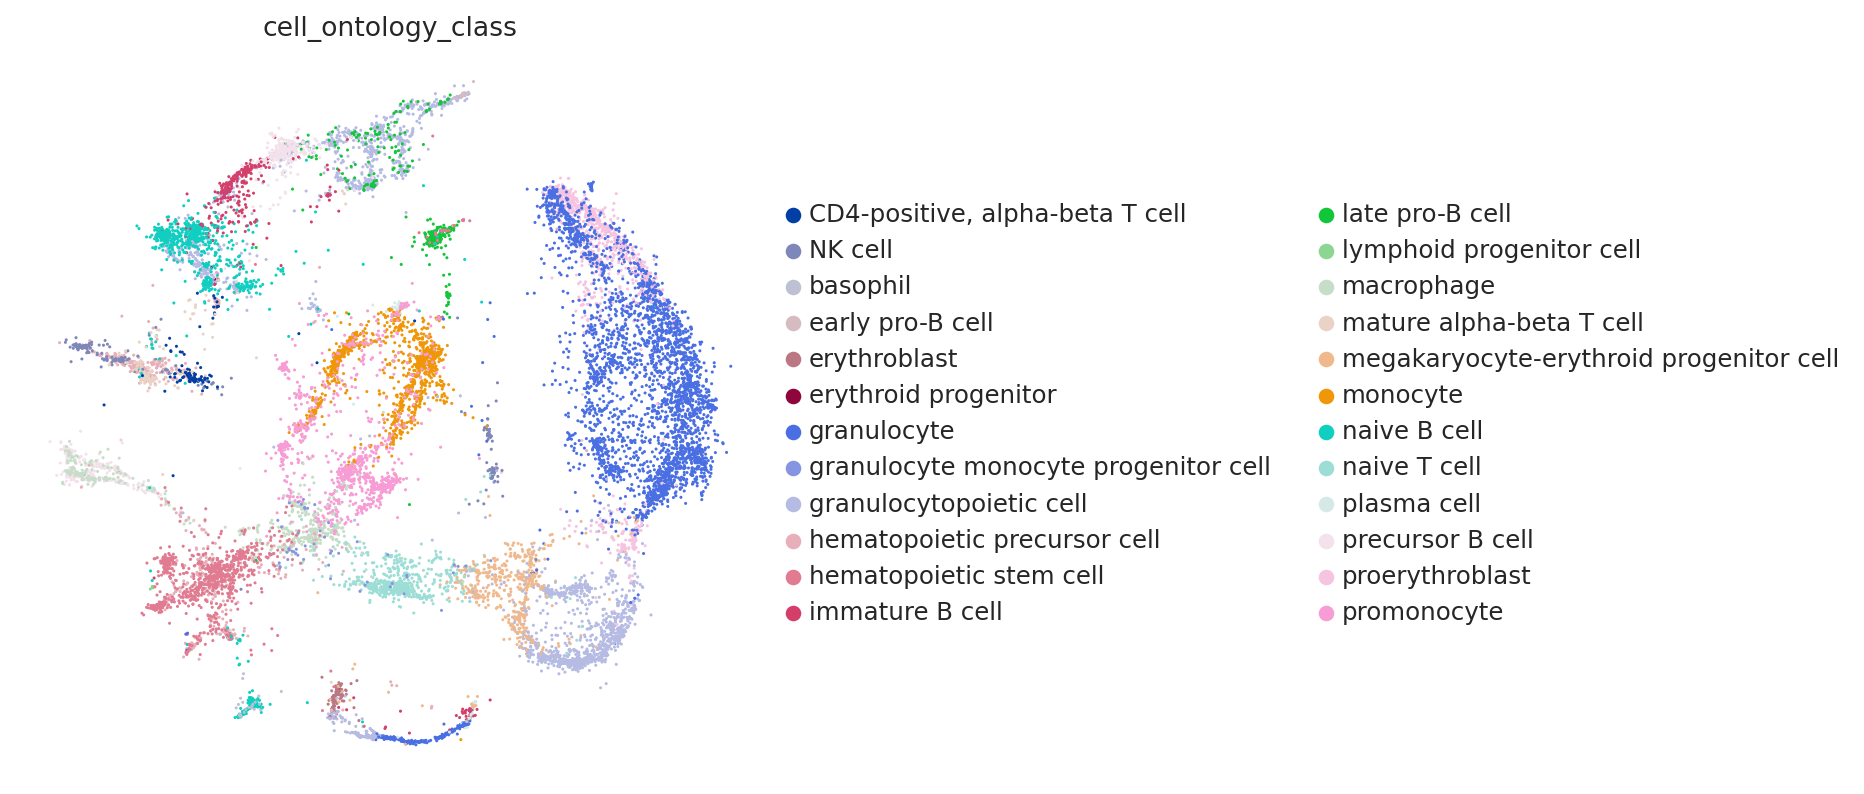

In [29]:
sc.pl.embedding(adata, color="cell_ontology_class", frameon=False, basis=SCVI_MDE_KEY)

In [31]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_ontology_class",
    unlabeled_category="Unknown",
)

In [32]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [01:06<00:00,  3.09s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.03e+3]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:06<00:00,  3.30s/it, v_num=1, train_loss_step=1.17e+3, train_loss_epoch=1.03e+3]


In [33]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [34]:
SCANVI_MDE_KEY = "X_scANVI_MDE"
adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCANVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


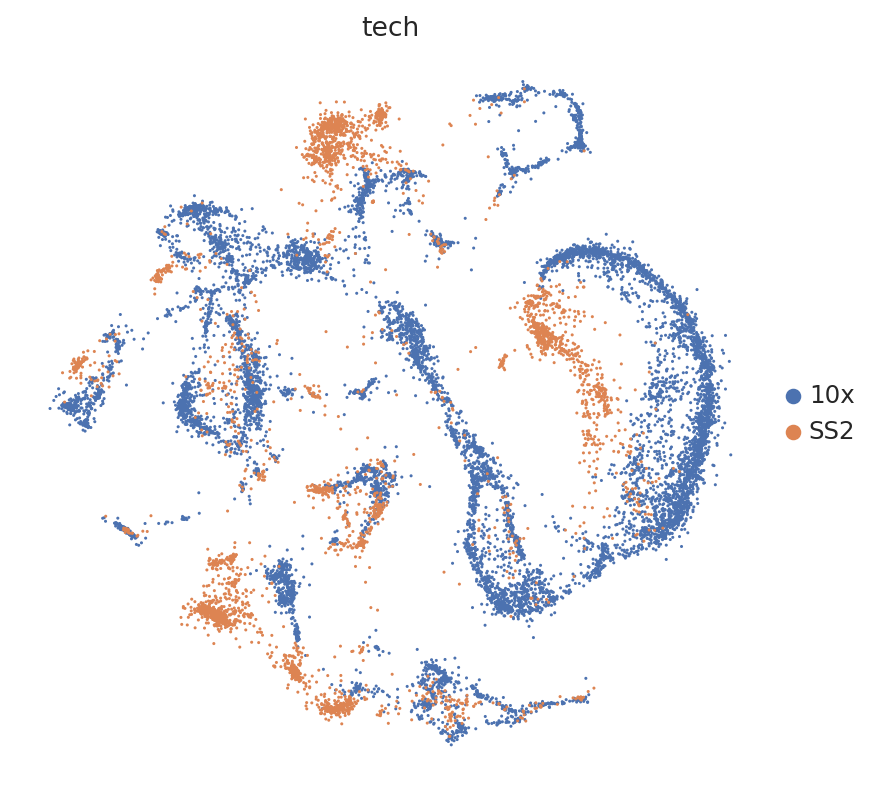

In [36]:
sc.pl.embedding(
    adata,
    basis=SCANVI_MDE_KEY,
    color=["tech"],
    frameon=False,
    ncols=1,
)

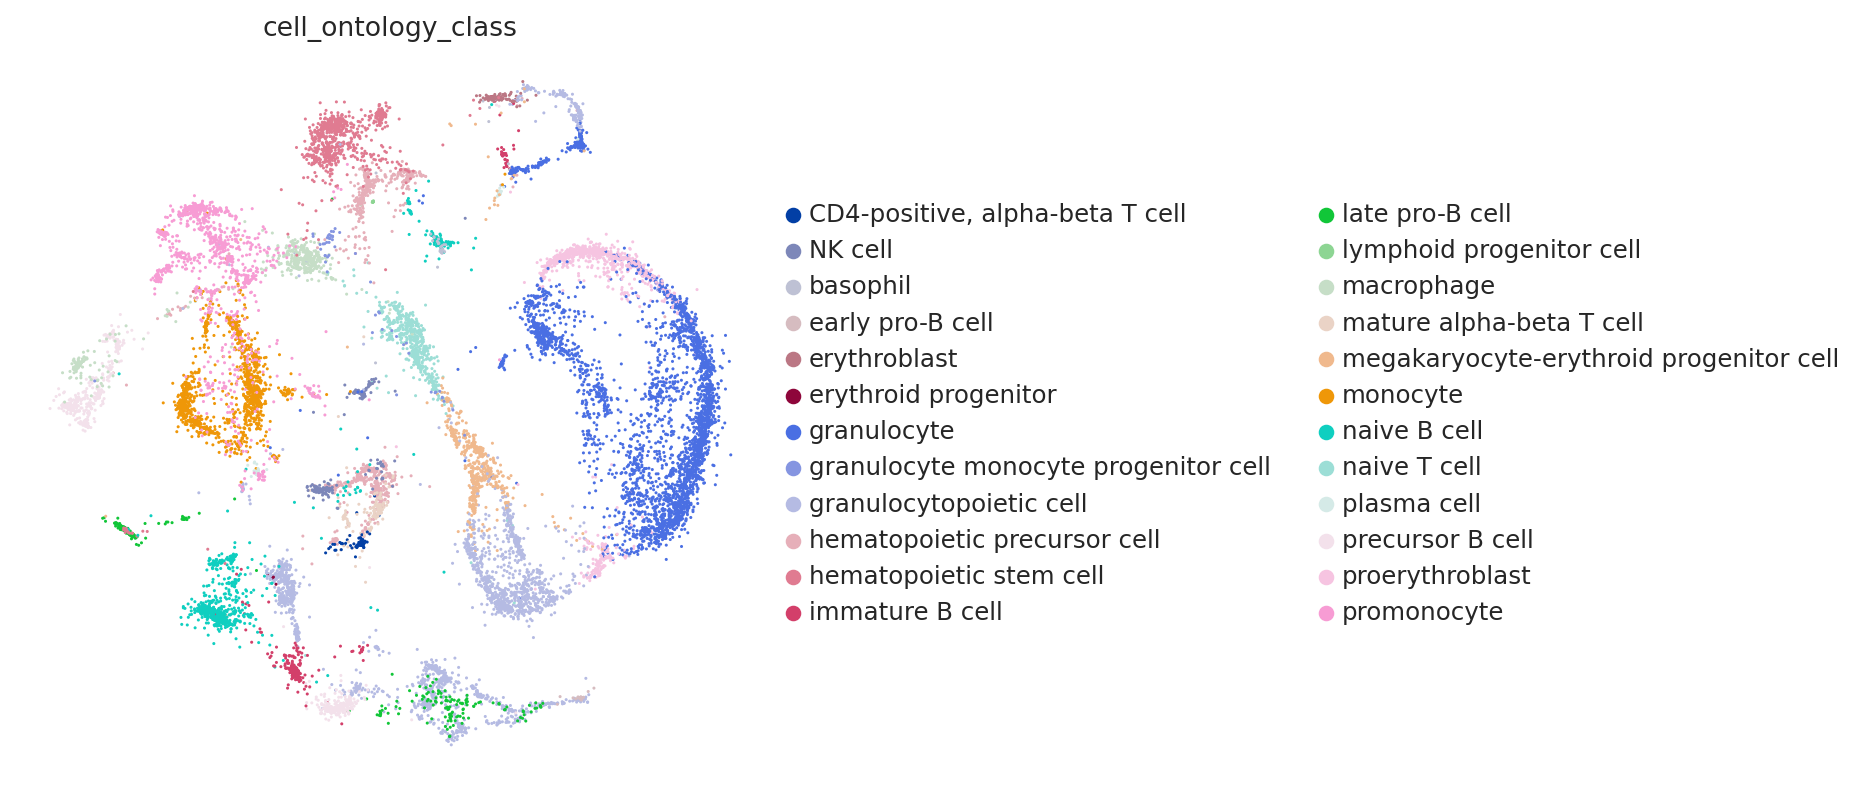

In [37]:
sc.pl.embedding(adata, color="cell_ontology_class", frameon=False, basis=SCANVI_MDE_KEY)



---

# Transfer of annotations with scANVI

Assumption: the SS2 data is annotated and the 10X data is not

In [38]:
SCANVI_CELLTYPE_KEY = "celltype_scanvi"

adata.obs[SCANVI_CELLTYPE_KEY] = "Unknown"
ss2_mask = adata.obs["tech"] == "SS2"
adata.obs[SCANVI_CELLTYPE_KEY][ss2_mask] = adata.obs.cell_ontology_class[ss2_mask].values

<ipython-input-38-7ed835f4cafd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[SCANVI_CELLTYPE_KEY][ss2_mask] = adata.obs.cell_ontology_class[ss2_mask].values


In [39]:
np.unique(adata.obs[SCANVI_CELLTYPE_KEY], return_counts=True)

(array(['CD4-positive, alpha-beta T cell', 'NK cell', 'Unknown',
        'basophil', 'early pro-B cell', 'granulocyte',
        'granulocyte monocyte progenitor cell', 'granulocytopoietic cell',
        'hematopoietic stem cell', 'immature B cell', 'late pro-B cell',
        'lymphoid progenitor cell', 'macrophage',
        'mature alpha-beta T cell',
        'megakaryocyte-erythroid progenitor cell', 'naive B cell',
        'precursor B cell', 'promonocyte'], dtype=object),
 array([  107,   139, 11707,    26,    24,   773,    52,    67,   894,
          281,   132,    13,   136,   150,    22,   740,   321,   323]))

In [40]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    unlabeled_category="Unknown",
    labels_key=SCANVI_CELLTYPE_KEY,
)

In [41]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [01:05<00:00,  3.29s/it, v_num=1, train_loss_step=967, train_loss_epoch=1.03e+3]    

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:05<00:00,  3.28s/it, v_num=1, train_loss_step=967, train_loss_epoch=1.03e+3]


In [42]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTION_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(adata)

In [44]:
SCANVI_MDE_KEY = "X_mde_scanvi"
adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCANVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


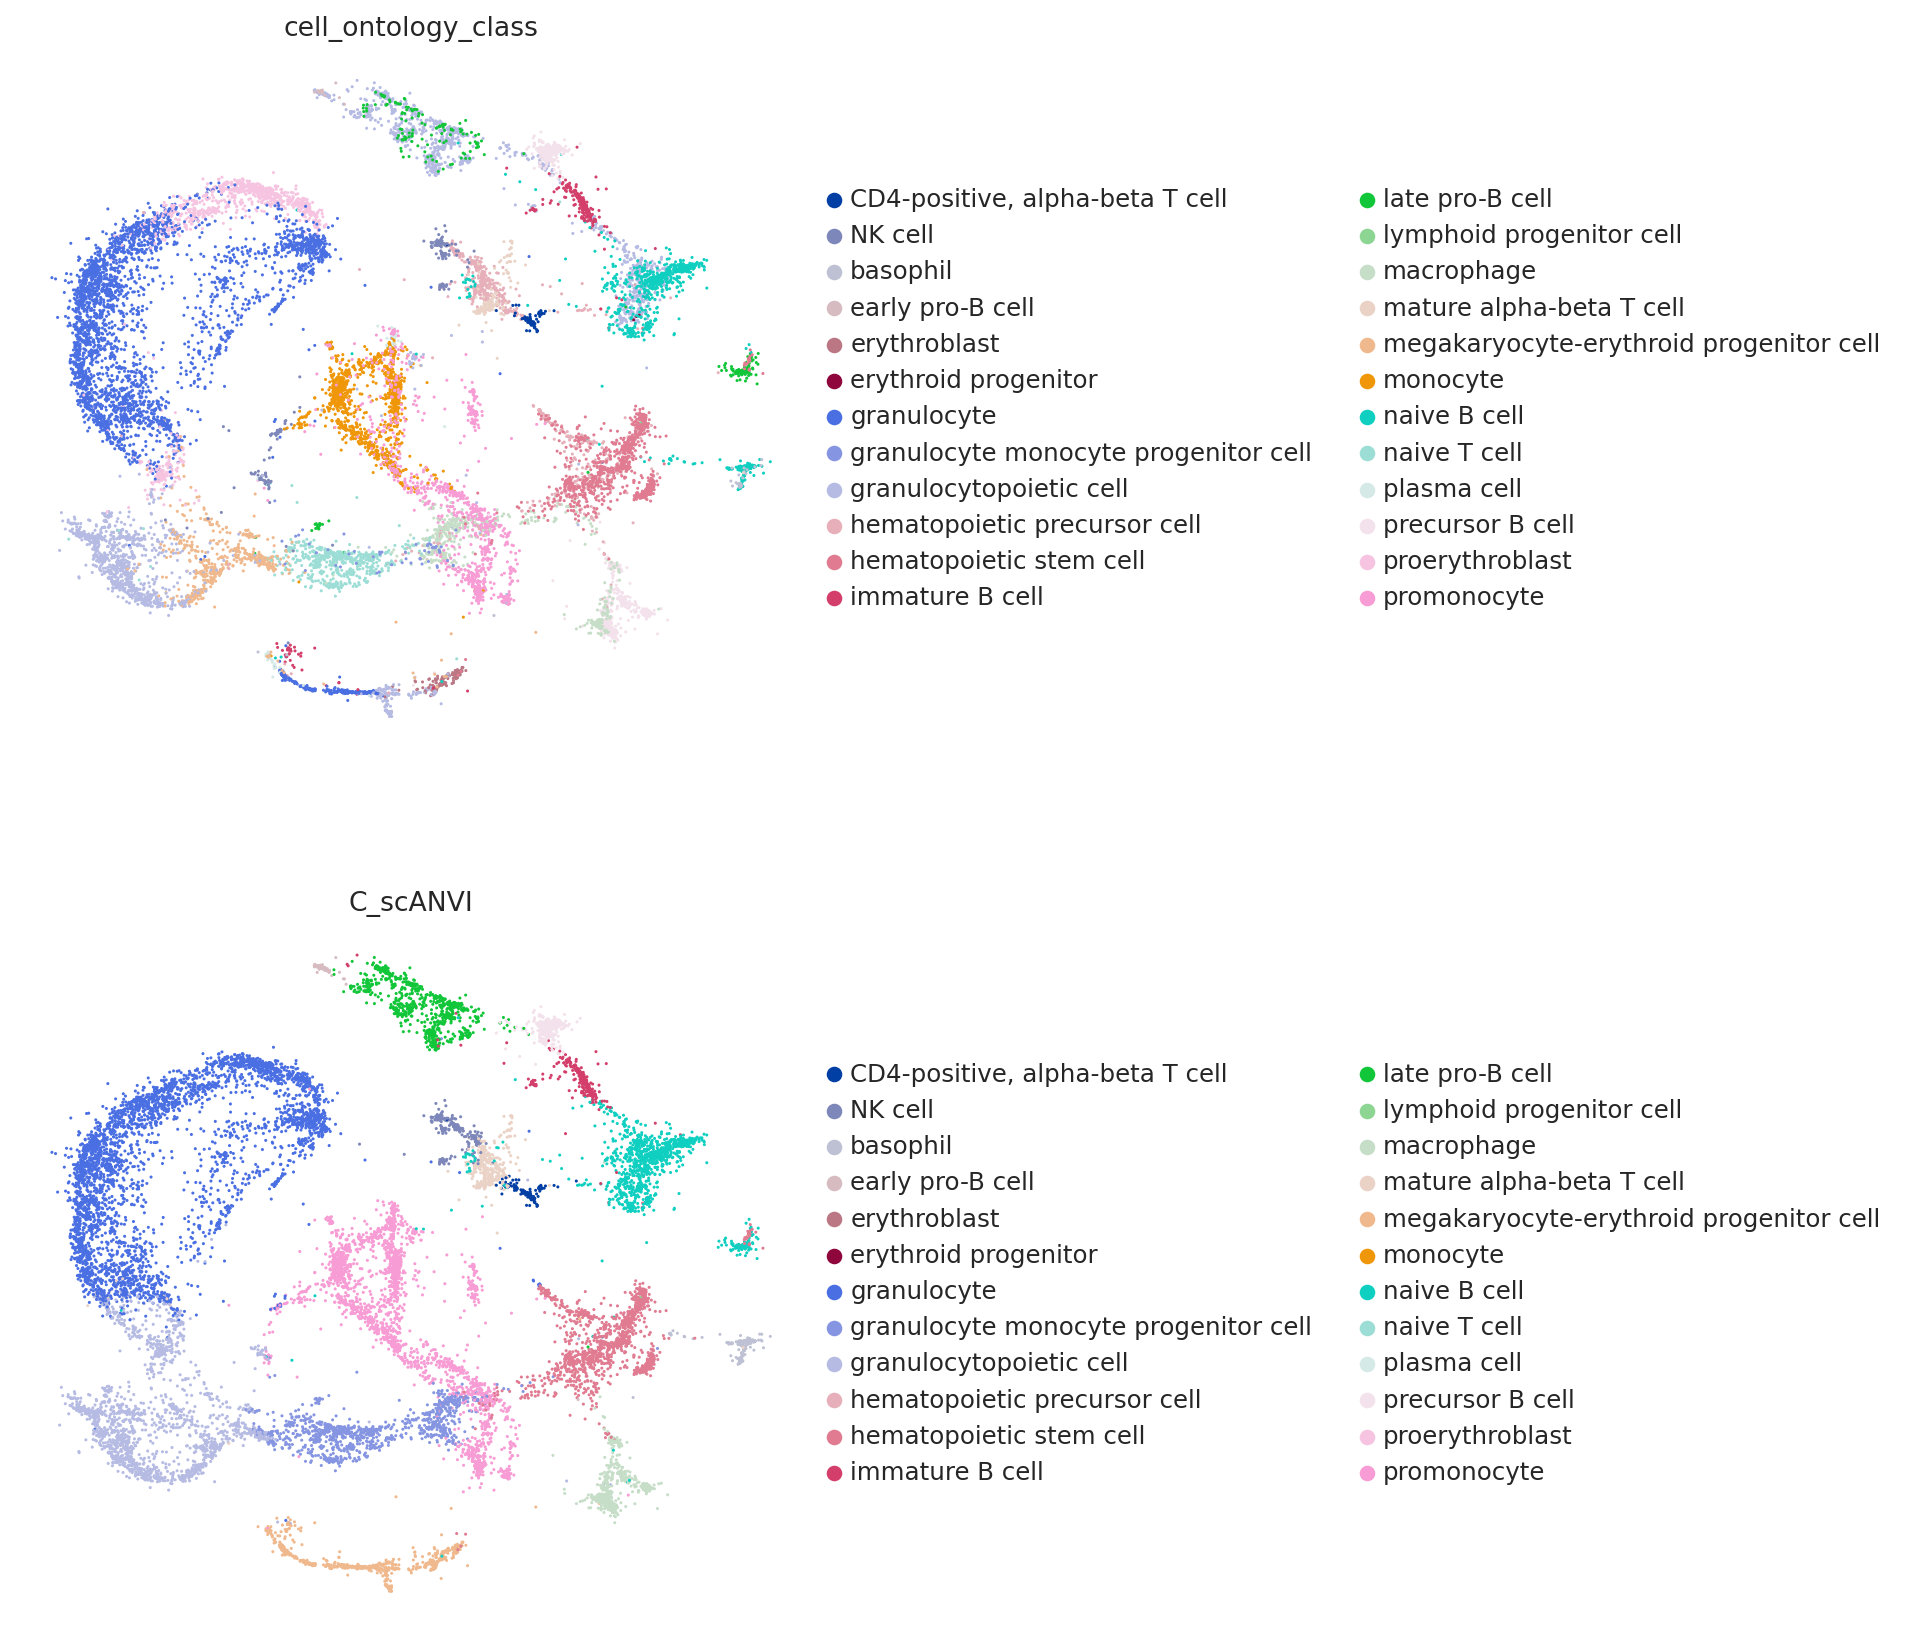

In [45]:
# in order to make colors matchup
adata.obs.C_scANVI = pd.Categorical(
    adata.obs.C_scANVI.values, categories=adata.obs.cell_ontology_class.cat.categories
)
sc.pl.embedding(
    adata,
    basis=SCANVI_MDE_KEY,
    color=["cell_ontology_class", SCANVI_PREDICTION_KEY],
    ncols=1,
    frameon=False,
    palette=adata.uns["cell_ontology_class_colors"],
)

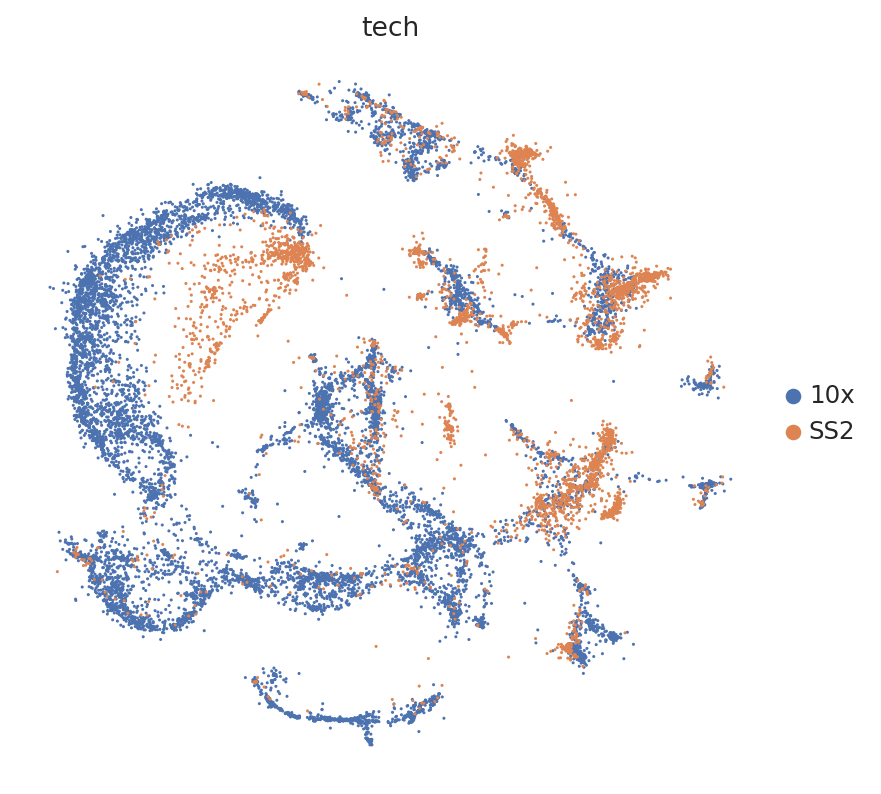

In [46]:
sc.pl.embedding(
    adata,
    basis=SCANVI_MDE_KEY,
    color=["tech"],
    frameon=False,
    ncols=1,
)

In [47]:
df = adata.obs.groupby(["cell_ontology_class", SCANVI_PREDICTION_KEY]).size().unstack(fill_value=0)

<ipython-input-47-a2f35354d504>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(["cell_ontology_class", SCANVI_PREDICTION_KEY]).size().unstack(fill_value=0)


In [48]:
conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

Text(0, 0.5, 'Observed')

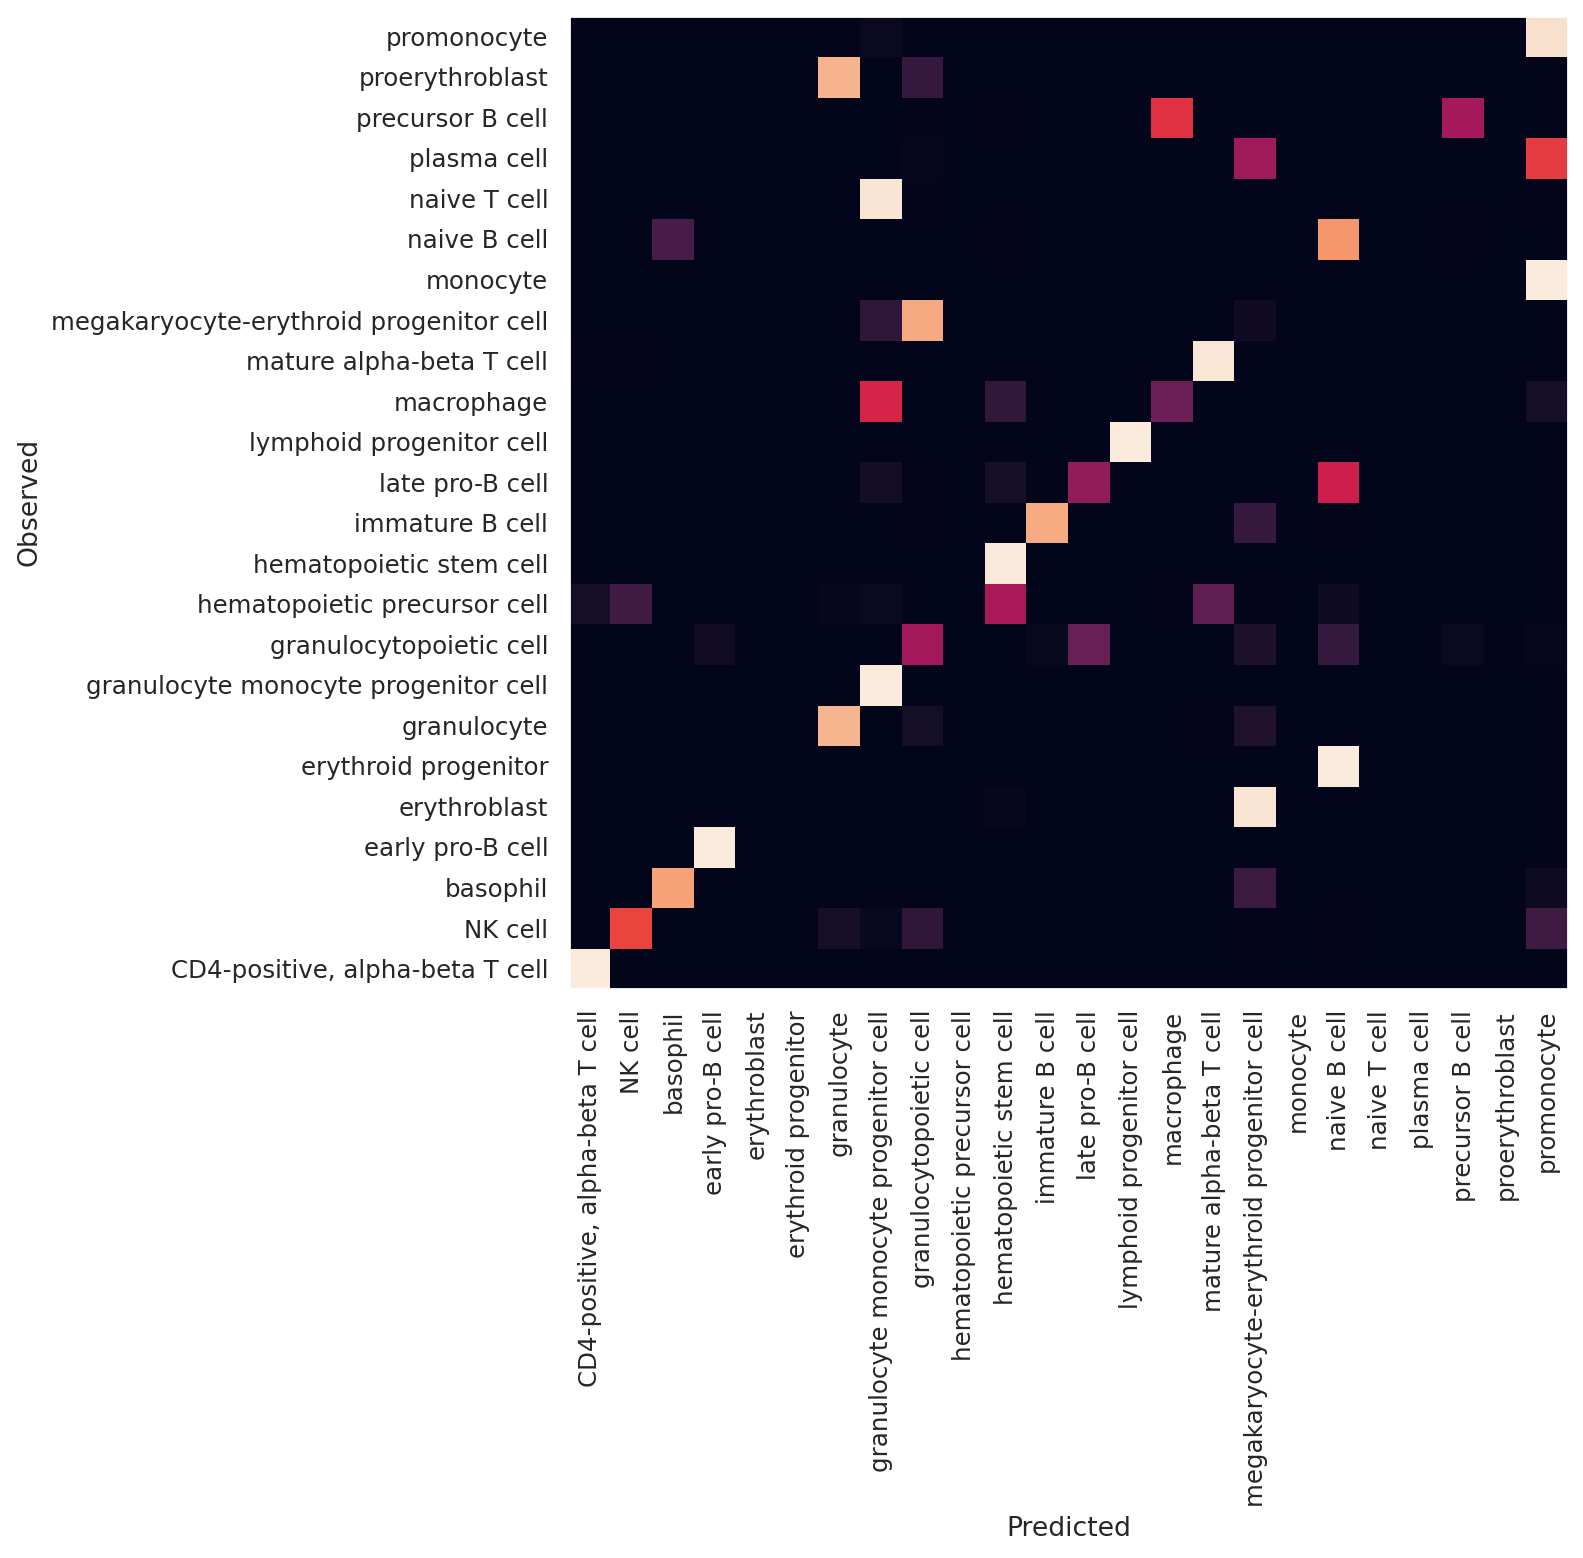

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
_ = plt.pcolor(conf_mat)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [67]:
import subprocess
result = subprocess.run(['pip', 'install', 'scib-metrics'], capture_output=True, text=True)
print(result.stdout)

In [72]:
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    adata,
    batch_key="tech",
    label_key="cell_ontology_class",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    n_jobs=-1,
)
bm.benchmark()

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Metrics:  60%|██████    | 6/10 [00:21<00:16,  4.20s/it, Batch correction: kbet_per_label]

INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     early pro-B cell consists of a single batch or is too small. Skip.                                        
INFO     erythroblast consists of a single batch or is too small. Skip.                                            
INFO     erythroid progenitor consists of a single batch or is too small. Skip.                                    


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     granulocyte monocyte progenitor cell consists of a single batch or is too small. Skip.                    


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     hematopoietic precursor cell consists of a single batch or is too small. Skip.                            
INFO     hematopoietic stem cell consists of a single batch or is too small. Skip.                                 


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     lymphoid progenitor cell consists of a single batch or is too small. Skip.                                


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     mature alpha-beta T cell consists of a single batch or is too small. Skip.                                


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     monocyte consists of a single batch or is too small. Skip.                                                


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     naive T cell consists of a single batch or is too small. Skip.                                            
INFO     plasma cell consists of a single batch or is too small. Skip.                                             


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     proerythroblast consists of a single batch or is too small. Skip.                                         


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)

Metrics:  70%|███████   | 7/10 [00:40<00:26,  8.80s/it, Batch correction: graph_connectivity]/usr/local/lib/python3.10/dist-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:05<00:04,  1.10s/it, Batch correction: kbet_per_label]

INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     early pro-B cell consists of a single batch or is too small. Skip.                                        
INFO     erythroblast consists of a single batch or is too small. Skip.                                            
INFO     erythroid progenitor consists of a single batch or is too small. Skip.                                    


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     granulocyte monocyte progenitor cell consists of a single batch or is too small. Skip.                    


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     hematopoietic precursor cell consists of a single batch or is too small. Skip.                            
INFO     hematopoietic stem cell consists of a single batch or is too small. Skip.                                 


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     lymphoid progenitor cell consists of a single batch or is too small. Skip.                                


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     mature alpha-beta T cell consists of a single batch or is too small. Skip.                                


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     monocyte consists of a single batch or is too small. Skip.                                                
INFO     naive T cell consists of a single batch or is too small. Skip.                                            
INFO     plasma cell consists of a single batch or is too small. Skip.                                             


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     proerythroblast consists of a single batch or is too small. Skip.                                         


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)

Metrics:  70%|███████   | 7/10 [00:21<00:12,  4.24s/it, Batch correction: graph_connectivity]/usr/local/lib/python3.10/dist-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:03<00:01,  2.05it/s, Batch correction: kbet_per_label]

INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     early pro-B cell consists of a single batch or is too small. Skip.                                        
INFO     erythroblast consists of a single batch or is too small. Skip.                                            
INFO     erythroid progenitor consists of a single batch or is too small. Skip.                                    


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     granulocyte monocyte progenitor cell consists of a single batch or is too small. Skip.                    


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     hematopoietic precursor cell consists of a single batch or is too small. Skip.                            
INFO     hematopoietic stem cell consists of a single batch or is too small. Skip.                                 


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     lymphoid progenitor cell consists of a single batch or is too small. Skip.                                
INFO     mature alpha-beta T cell consists of a single batch or is too small. Skip.                                


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     monocyte consists of a single batch or is too small. Skip.                                                


/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     naive T cell consists of a single batch or is too small. Skip.                                            
INFO     plasma cell consists of a single batch or is too small. Skip.                                             
INFO     proerythroblast consists of a single batch or is too small. Skip.                                         



Metrics:  70%|███████   | 7/10 [00:15<00:08,  2.97s/it, Batch correction: graph_connectivity]/usr/local/lib/python3.10/dist-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|██████████| 3/3 [01:19<00:00, 26.55s/it]

                                                                                         

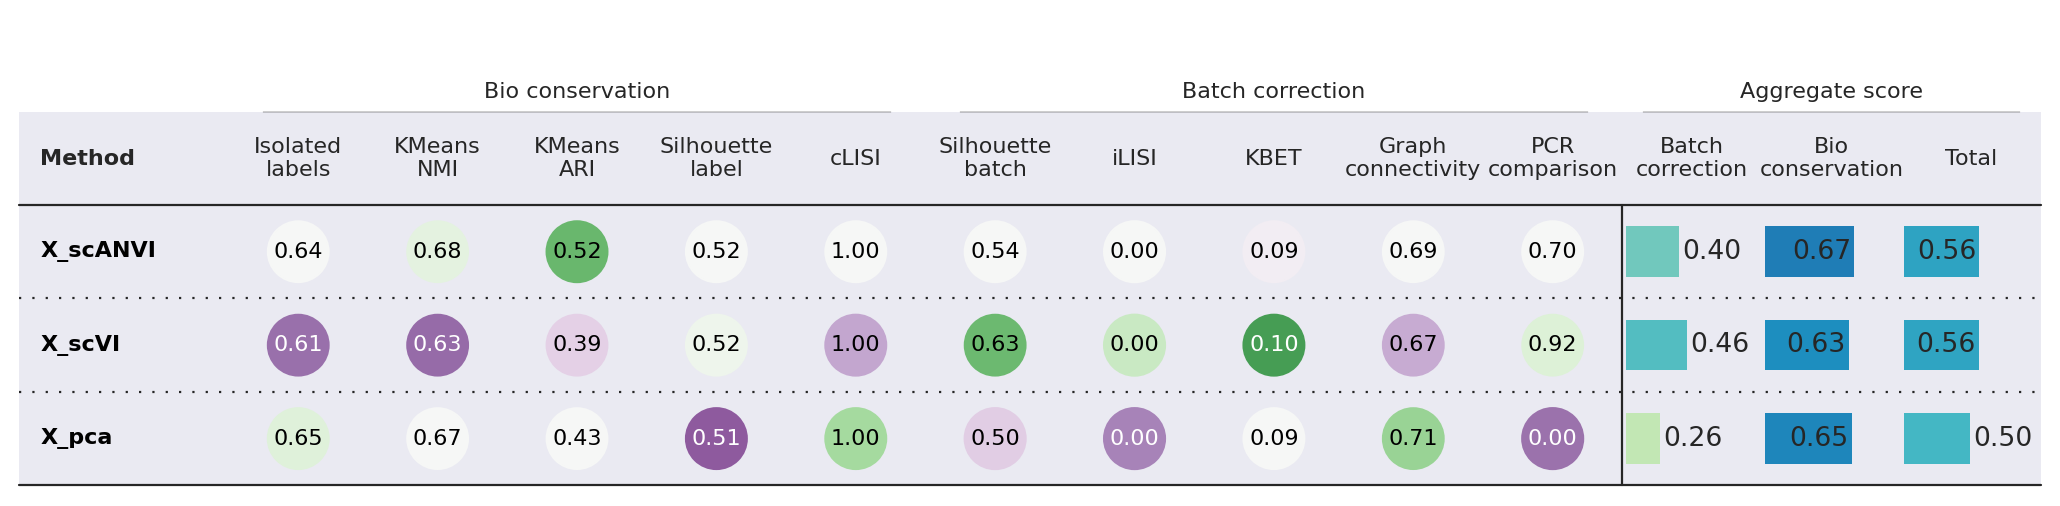

In [75]:
bm.plot_results_table(min_max_scale=False)

In [78]:
df = bm.get_results(min_max_scale=False)
df.transpose()

Embedding,X_pca,X_scVI,X_scANVI,Metric Type
Isolated labels,0.647935,0.607653,0.639607,Bio conservation
KMeans NMI,0.672049,0.634445,0.680119,Bio conservation
KMeans ARI,0.426835,0.38989,0.524873,Bio conservation
Silhouette label,0.513082,0.518112,0.517681,Bio conservation
cLISI,0.999853,0.99695,0.998381,Bio conservation
Silhouette batch,0.49944,0.626459,0.537136,Batch correction
iLISI,0.0,0.0,0.0,Batch correction
KBET,0.088575,0.095819,0.087914,Batch correction
Graph connectivity,0.712204,0.666489,0.687567,Batch correction
PCR comparison,0.0,0.917176,0.703992,Batch correction


In [79]:
adata

AnnData object with n_obs × n_vars = 15907 × 2000
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tech', '_scvi_batch', '_scvi_labels', 'celltype_scanvi', 'C_scANVI'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'tech_colors', 'cell_ontology_class_colors', 'C_scANVI_colors', 'pca'
    obsm: 'X_scVI', 'X_scVI_mde', 'X_scANVI', 'X_scANVI_MDE', 'X_mde_scanvi', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [80]:
import sys
import platform

print("Python version:", sys.version)
print("Platform:", platform.platform())

Python version: 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
Platform: Linux-6.1.85+-x86_64-with-glibc2.35
